In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Regression on whether data
#### Data preprocessing - normalisation, shuffling required? 
1. normalisation done in gradient descent application
2. shuffling not required as this is a regression problem

#### Note
1. validation <=> test
2. train <=> train
3. test <=> TEST
4. Quanitity_CV means it is used to get using cross validation 

In [12]:
data = pd.read_excel('./weather_data.xlsx').values
print(type(data), data.shape)
print(data[:5,:])

#augment dataset (X)
ones=np.ones((data.shape[0], 1))
data=np.hstack((ones,data))
print(type(data), data.shape)

<class 'numpy.ndarray'> (1000, 7)
[[  28   59   20 1008    0    0   20]
 [  48   61   10 1012    1    0   21]
 [  24   53    3 1001    0    0   16]
 [  17   54    8 1002    0    0   16]
 [  27   51    5 1007    0    0   14]]
<class 'numpy.ndarray'> (1000, 8)


In [13]:
train_data=data[:700,:].astype('float64')
TEST_data=data[700:,:].astype('float64')

mean = train_data[:,1:-1].mean(axis=0,keepdims=True)
stddev = train_data[:,1:-1].std(axis=0,keepdims=True)
print("mean",mean)
print("stddev",stddev)

train_data[:,1:-1]-=mean
train_data[:,1:-1]/=stddev
TEST_data[:,1:-1]-=mean
TEST_data[:,1:-1]/=stddev

Cross_Validation_data=np.array_split(train_data,5)
print(len(Cross_Validation_data))

X_TEST,y_TEST = TEST_data[:,:-1],TEST_data[:,-1:]
print(X_TEST.shape, y_TEST.shape)

mean [[2.93814286e+01 4.92828571e+01 1.26957143e+01 1.00992143e+03
  3.00000000e-01 2.55714286e-01]]
stddev [[12.44055342 14.60205437  4.70564815  5.07214784  0.45825757  0.43626195]]
5
(300, 7) (300, 1)


# Linear Model : y_ = w.T.dot(x)
1. Try different loss functions
2. Try with/without regularization
3. Give both analytical and numerical (grad descent) solution --> both SGD and GD

## Loss function - MSE
### Closed form Solution - without regularization

In [14]:
def mse_loss(Y_true,Y_pred):
    return ((Y_true-Y_pred)**2).mean()
def Get_W_NoReg(X,y):
    return (np.linalg.inv(X.T.dot(X))).dot(X.T).dot(y)

In [15]:
#cross validate
def cross_validate(Cross_Validation_data):
    train_error_CV, test_error_CV = [],[]
    print("train size %u, val size %u"%(train_data.shape[0]-Cross_Validation_data[0].shape[0],Cross_Validation_data[0].shape[0]) )
    for i,validation_data in enumerate(Cross_Validation_data):
        remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
        X_train, y_train = remaining_data_for_training[:,:-1], remaining_data_for_training[:,-1:]
        X_test, y_test = validation_data[:,:-1], validation_data[:,-1:]

        w = Get_W_NoReg(X_train,y_train)

        y_pred_train = X_train.dot(w)
        y_pred_test = X_test.dot(w)

        train_error_CV.append(mse_loss(y_train, y_pred_train))
        test_error_CV.append(mse_loss(y_test, y_pred_test))

    n_cv = len(train_error_CV)
    train_error, test_error = sum(train_error_CV)/n_cv, sum(test_error_CV)/n_cv
    return train_error, test_error

In [16]:
cross_validate(Cross_Validation_data)

train size 560, val size 140


(2.648591586168366, 2.826535336366582)

In [17]:
#FINALLY, train on complete TRAIN set and evaluate on TEST set
w = Get_W_NoReg(train_data[:,:-1],train_data[:,-1:])

y_pred_train = train_data[:,:-1].dot(w)
y_pred_TEST = X_TEST.dot(w)

print("train error, TEST error",mse_loss(train_data[:,-1:], y_pred_train), mse_loss(y_TEST, y_pred_TEST))

train error, TEST error 2.66594770033124 3.508677050035615


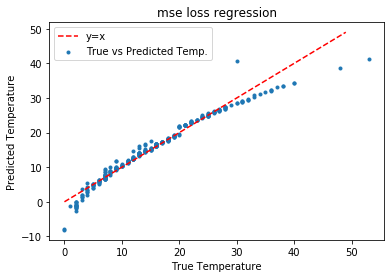

In [18]:
plt.title('mse loss regression')
plt.scatter(y_TEST, y_pred_TEST,label='True vs Predicted Temp.',marker='.')
a=np.arange(0,50,1)
plt.plot(a,a,label='y=x',color='r',linestyle='dashed')
plt.xlabel('True Temperature')
plt.ylabel('Predicted Temperature')
plt.legend()
plt.savefig('MSE_regressor.png')
plt.show()

### Analytical Solution - with L2 regularization

In [57]:
def Get_W_L2_Reg(X,y,alpha):
    return (np.linalg.inv(X.T.dot(X) + alpha*np.identity(7))).dot(X.T).dot(y)

In [58]:
#cross validation
def cross_validate(Cross_Validation_data, alpha):
    train_error_CV, test_error_CV = [],[]
    for i,validation_data in enumerate(Cross_Validation_data):
        remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
        X_train, y_train = remaining_data_for_training[:,:-1], remaining_data_for_training[:,-1:]
        X_test, y_test = validation_data[:,:-1], validation_data[:,-1:]

        w = Get_W_L2_Reg(X_train,y_train,alpha)

        y_pred_train = X_train.dot(w)
        y_pred_test = X_test.dot(w)

        train_error_CV.append(mse_loss(y_train, y_pred_train))
        test_error_CV.append(mse_loss(y_test, y_pred_test))

    n_cv = len(train_error_CV)
    train_error, test_error = sum(train_error_CV)/n_cv, sum(test_error_CV)/n_cv
    return train_error, test_error

In [59]:
alphas = list(np.arange(0,50000,1000))
train_errors, test_errors, TEST_errors, Ws = [], [], [], []

for alpha in alphas:
    print('alpha %u'%alpha,end='\r')
    train_error, test_error = cross_validate(Cross_Validation_data, alpha)
    
    w = Get_W_L2_Reg(train_data[:,:-1],train_data[:,-1:],alpha)
    y_pred_TEST = X_TEST.dot(w)
    
    TEST_errors.append(mse_loss(y_TEST, y_pred_TEST))
    train_errors.append(train_error)
    test_errors.append(test_error)
    Ws.append(w)

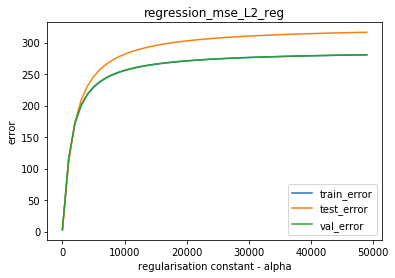

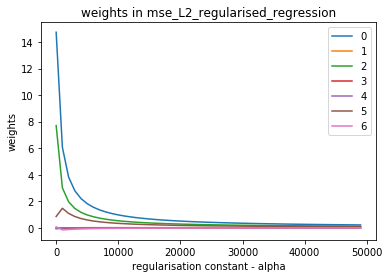

In [60]:
Ws=np.array(Ws)
plt.title('regression_mse_L2_reg')
plt.xlabel('regularisation constant - alpha')
plt.ylabel('error')
plt.plot(alphas,train_errors,label='train_error')
plt.plot(alphas,TEST_errors,label='test_error')
plt.plot(alphas,test_errors,label='val_error')
plt.legend()
plt.show()
plt.title('weights in mse_L2_regularised_regression')
plt.xlabel('regularisation constant - alpha')
plt.ylabel('weights')
for j in range(7):
    plt.plot(alphas,Ws[:,j,0],label=str(j))
plt.legend()
plt.show()

#### Inference - regularising increases the train and test error. Thus no use of regularisation unless overfitting is there!

# Comparison between Closed form and Gradient Descent Solution
#### Gradient Descent - inferences:
1. when LR is high, we see exploding and vanishing gradients 
2. when I decrease the LR by factor of 10 during the training phase, like in neural networks training, there is no fall in train/test error, unlike in NN training. This is because the cost function is exactly quadratic (due to mse and simple wTx hypothesis).

In [61]:
def mse_loss(Y_true,Y_pred):
    return ((Y_true-Y_pred)**2).mean()

def GradientDescent(X_train,y_train, X_test,y_test, epochs, lr):    
    train_error, test_error = [], []
    n,m=X_train.shape
    
    #initialise weights
    w = np.random.random((m,1))
    for _ in range(epochs):
        y_pred_train = X_train.dot(w)
        y_pred_test = X_test.dot(w)
        
        gradient = 2*((X_train.T).dot(y_pred_train - y_train)) / n
#         if _ == epochs//2:
#             lr/=10
        w = w - lr * gradient
        
        train_error.append(mse_loss(y_train, y_pred_train))
        test_error.append(mse_loss(y_test, y_pred_test))
    
    return w, train_error, test_error

#cross validation
def cross_validate(Cross_Validation_data, lr):
    #cross validate
    train_error_CV, test_error_CV = [],[]
    for i,validation_data in enumerate(Cross_Validation_data):
        remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
        X, y_train = remaining_data_for_training[:,:-1], remaining_data_for_training[:,-1:]
        Xt, y_test = validation_data[:,:-1], validation_data[:,-1:]

        w, train_error, test_error = GradientDescent(X, y_train, Xt, y_test, epochs=150, lr=lr)

        train_error_CV.append(train_error)
        test_error_CV.append(test_error)

    n_cv = len(train_error_CV)
    train_error, test_error = np.array(train_error_CV).sum(axis=0)/5, np.array(test_error_CV).sum(axis=0)/5
    return train_error, test_error

train_error 2.6485915863335854 test error 2.826530318542834
train_error 4.015513519070689 test error 4.247855390278286
train_error 138.68930063957458 test error 139.43741761327095


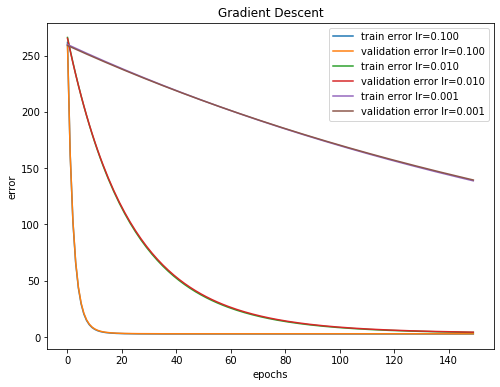

In [62]:
plt.figure(figsize=(8.,6.))
plt.title('Gradient Descent')
for lr in [.1, .01, 0.001]:
    train_error, test_error = cross_validate(Cross_Validation_data, lr)
    print("train_error", train_error[-1],"test error",test_error[-1])
    plt.xlabel('epochs')
    plt.ylabel('error')
    plt.plot(train_error,label='train error lr=%.3f'%lr)
    plt.plot(test_error,label='validation error lr=%.3f'%lr)
    plt.legend()
#     plt.show()
plt.savefig('grad_descent.png')
plt.show()

In [63]:
# train on complete TRAIN set and evaluate on complete TEST set
X=train_data[:,:-1]
Xt=TEST_data[:,:-1]
w, train_error, TEST_error = GradientDescent(X, train_data[:,-1:], Xt, TEST_data[:,-1:], epochs=150, lr=0.1)
print("w",w)
print("train error, TEST error",train_error[-1], TEST_error[-1])

w [[ 1.47457143e+01]
 [-4.84610602e-03]
 [ 7.69835820e+00]
 [-4.78597816e-02]
 [-8.30552523e-02]
 [ 8.45444324e-01]
 [ 6.71314214e-02]]
train error, TEST error 2.6659477004038017 3.5086768138138194


### Gradient Descent with regularizer
L2 - cost = ||Y-XW||^2/n + alpha*||w||^2 

In [64]:
def regularized_mse_loss(y_true,y_pred, alpha, w):
    return ((y_true-y_pred)**2).mean() + alpha*(w.T.dot(w)[0,0])

def mse_loss(Y_true,Y_pred):
    return ((Y_true-Y_pred)**2).mean()

def GradientDescent(X_train,y_train, X_test,y_test, epochs, lr, alpha):
    train_error, test_error = [], []
    n,m=X_train.shape
    
    #initialise weights
    w = np.random.random((m,1))
    for _ in range(epochs):
        y_pred_train = X_train.dot(w)
        y_pred_test = X_test.dot(w)
        
        gradient = (2*((X_train.T).dot(y_pred_train - y_train)) / n) + 2*alpha*w
        
        w = w - lr * gradient
                
        train_error.append(mse_loss(y_train, y_pred_train))
        test_error.append(mse_loss(y_test, y_pred_test))
    return w, train_error, test_error

train_error 2.6682222635392248 test error 3.5098326799498403
TEST error 3.5095468404533237

train_error 33.070056283806274 test error 37.81811803520222
TEST error 37.818072644452656

train_error 70.53807831865807 test error 79.64285907988449
TEST error 79.64285898098666

train_error 123.93453510458818 test error 139.63467974569198
TEST error 139.63467974569195



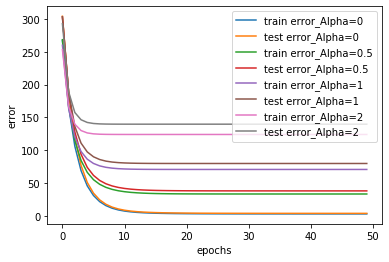

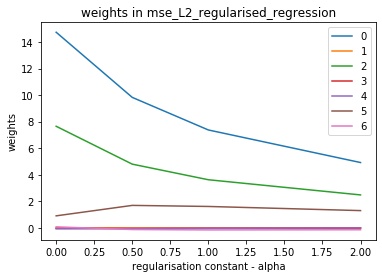

In [65]:
X, y_train = train_data[:,:-1], train_data[:,-1:]
Xt, y_TEST = TEST_data[:,:-1], TEST_data[:,-1:]

Ws,alphas=[],[0, .5, 1, 2]
for alpha in alphas:
    w, train_error, test_error = GradientDescent(X,y_train,Xt,y_TEST,50,0.1,alpha)
    
    print("train_error", train_error[-1],"test error",test_error[-1])
    plt.xlabel('epochs')
    plt.ylabel('error')
    plt.plot(train_error,label='train error_Alpha={}'.format(alpha))
    plt.plot(test_error,label='test error_Alpha={}'.format(alpha))
    plt.legend()
#     plt.show()
    y_pred_TEST = (Xt).dot(w)
    print("TEST error", mse_loss(y_TEST, y_pred_TEST))
    print()
    Ws.append(w)
Ws=np.array(Ws)
plt.show()
plt.title('weights in mse_L2_regularised_regression')
plt.xlabel('regularisation constant - alpha')
plt.ylabel('weights')
for j in range(7):
    plt.plot(alphas,Ws[:,j,0],label=str(j))
plt.legend()
plt.show()

#### Inferences
1. regularisation worsens off the regressor
2. LR should be sufficiently high

### Stochastic Gradient Descent without regularizer

note: in plots, I am plotting iterations (not epochs). iterations = number of times a subdataset is processed from the dataset

In [66]:
def mse_loss(Y_true,Y_pred):
    return ((Y_true-Y_pred)**2).mean()

def StochasticGradientDescent(X_train,y_train, X_test,y_test, epochs, lr, batch_size):    
    train_error, test_error = [], []
    n,m=X_train.shape
    
    #initialise weights
    w = np.random.random((m,1))
    for _ in range(epochs):
        X_train_mini_batches = np.array_split(X_train, n//batch_size)
        y_train_mini_batches = np.array_split(y_train, n//batch_size)
        for __ in range(len(X_train_mini_batches)):
            X_train_mini_batch = X_train_mini_batches[__]
            y_train_mini_batch = y_train_mini_batches[__]
            
            y_pred_train = X_train_mini_batch.dot(w)
            y_pred_test = X_test.dot(w)
        
            gradient = 2*((X_train_mini_batch.T).dot(y_pred_train - y_train_mini_batch)) / batch_size
        
            w = w - lr * gradient
        
            train_error.append(mse_loss(y_train_mini_batch, y_pred_train))
            test_error.append(mse_loss(y_test, y_pred_test))
    
    return w, train_error, test_error

In [69]:
#cross validation
def cross_validate(Cross_Validation_data, lr, batch_size,epochs):
    #cross validate
    train_error_CV, test_error_CV = [],[]
    for i,validation_data in enumerate(Cross_Validation_data):
        remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
        X, y_train = remaining_data_for_training[:,:-1], remaining_data_for_training[:,-1:]
        Xt, y_test = validation_data[:,:-1], validation_data[:,-1:]

        w, train_error, test_error = StochasticGradientDescent(X, y_train, Xt, y_test, epochs=epochs, lr=lr, batch_size=batch_size)

        train_error_CV.append(train_error)
        test_error_CV.append(test_error)

    n_cv = len(train_error_CV)
    train_error, test_error = np.array(train_error_CV).sum(axis=0)/5, np.array(test_error_CV).sum(axis=0)/5
    return train_error, test_error

train_error 2.562540576247996 test error 2.8351349876816836
train_error 3.978993530052167 test error 4.6188275837363255
train_error 142.03028273172123 test error 147.87204179643422


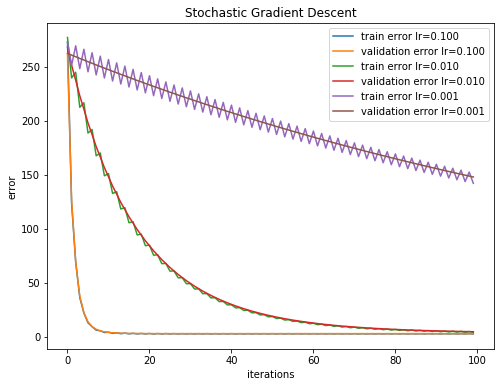

In [70]:
plt.figure(figsize=(8.,6.))
plt.title('Stochastic Gradient Descent')
for lr in [.1, .01, 0.001]:
    train_error, test_error = cross_validate(Cross_Validation_data, lr, batch_size=200,epochs=50)
    print("train_error", train_error[-1],"test error",test_error[-1])
    plt.xlabel('iterations')
    plt.ylabel('error')
    plt.plot(train_error,label='train error lr=%.3f'%lr)
    plt.plot(test_error,label='validation error lr=%.3f'%lr)
    plt.legend()
#     plt.show()
plt.savefig('stoch_grad_descent.png')
plt.show()

train_error 3.70164726190527 test error 3.2286094858417504


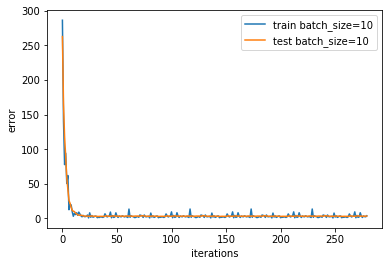

train_error 2.251183428394877 test error 2.8662332415817833


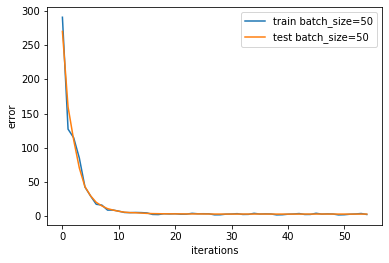

train_error 3.2137494666325828 test error 2.9105740365329593


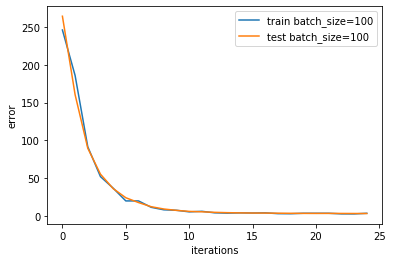

train_error 3.841812879278804 test error 4.497343557525184


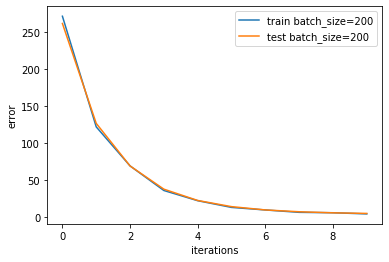

In [71]:
for batch_size in [10,50, 100, 200]:
    train_error, test_error = cross_validate(Cross_Validation_data, lr=0.1, batch_size=batch_size,epochs=5)
    print("train_error", train_error[-1],"test error",test_error[-1])
    plt.xlabel('iterations')
    plt.ylabel('error')
    plt.plot(train_error,label='train batch_size={}'.format(batch_size))
    plt.plot(test_error,label='test batch_size={}'.format(batch_size))
    plt.legend()
    plt.show()
# plt.show()

In [72]:
X=train_data[:,:-1]
Xt=TEST_data[:,:-1]
w, train_error, TEST_error = StochasticGradientDescent(X, train_data[:,-1:], Xt, TEST_data[:,-1:], epochs=150, lr=0.1, batch_size= 200)
print("w",w)
print("train error, TEST error",train_error[-1], TEST_error[-1])

w [[ 1.47638894e+01]
 [ 8.38333084e-03]
 [ 7.64714628e+00]
 [-3.97308391e-02]
 [-1.10427117e-01]
 [ 8.43169732e-01]
 [ 8.12530095e-02]]
train error, TEST error 2.817428361904999 3.5109320483566946


## Lasso and elastic regularisation
https://en.wikipedia.org/wiki/Regularized_least_squares => no closed form solution for l1 and elastic net reg

### Gradient Descent with L1 regularizer
L1 - cost = ||Y-XW||^2/n + alpha*||w|| 

In [73]:
def GradientDescent_L1(X_train,y_train, X_test,y_test, epochs, lr, alpha):
    train_error, test_error = [], []
    n,m=X_train.shape
    
    #initialise weights
    w = np.random.random((m,1))
    for _ in range(epochs):
        y_pred_train = X_train.dot(w)
        y_pred_test = X_test.dot(w)
        
        w_L1_gradient = np.sign(w)
        gradient = (2*((X_train.T).dot(y_pred_train - y_train)) / n) + alpha*w_L1_gradient
        
        w = w - lr * gradient
                
        train_error.append(mse_loss(y_train, y_pred_train))
        test_error.append(mse_loss(y_test, y_pred_test))
    return w, train_error, test_error

In [74]:
def GradientDescent_L2(X_train,y_train, X_test,y_test, epochs, lr, alpha):
    train_error, test_error = [], []
    n,m=X_train.shape
    
    #initialise weights
    w = np.random.random((m,1))
    for _ in range(epochs):
        y_pred_train = X_train.dot(w)
        y_pred_test = X_test.dot(w)
        
        gradient = (2*((X_train.T).dot(y_pred_train - y_train)) / n) + 2*alpha*w
        
        w = w - lr * gradient
                
        train_error.append(mse_loss(y_train, y_pred_train))
        test_error.append(mse_loss(y_test, y_pred_test))
    return w, train_error, test_error

In [75]:
alphas=[0,1,5,10,20,30,40]
lrs_l1=[0.1,0.1,0.01,0.01,1e-3,1e-3,1e-3,1e-3]
lrs_l2=[0.1,0.1,0.01,0.01,1e-3,1e-3,1e-3,1e-3]
ws_L1, train_error_L1, TEST_error_L1 = [], [], []
ws_L2, train_error_L2, TEST_error_L2 = [], [], []
for i,alpha in enumerate(alphas):
    w, train_error, test_error = GradientDescent_L1(X,y_train,Xt,y_TEST,epochs=1000,lr=lrs_l1[i],alpha=alpha)
    ws_L1.append(w), train_error_L1.append(train_error[-1]), TEST_error_L1.append(test_error[-1])

    w, train_error, test_error = GradientDescent_L2(X,y_train,Xt,y_TEST,epochs=300,lr=lrs_l2[i],alpha=alpha)
    ws_L2.append(w), train_error_L2.append(train_error[-1]), TEST_error_L2.append(test_error[-1])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


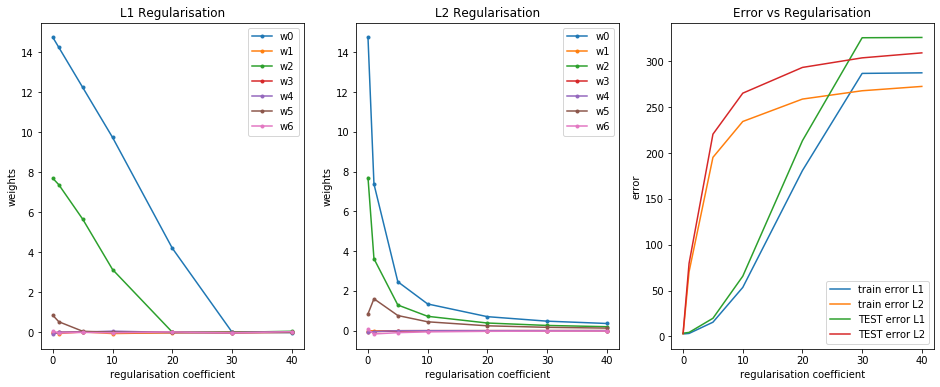

In [76]:
plt.figure(figsize=(16.,6.))
ws_L1=np.array(ws_L1)
ws_L2=np.array(ws_L2)
for j in range(7):
    plt.subplot(1,3,1)
    plt.title('L1 Regularisation')
    plt.xlabel('regularisation coefficient')
    plt.ylabel('weights')
    plt.plot(alphas,ws_L1[:,j,0],label='w%u'%j,marker='.')
    plt.legend()
# plt.savefig('L1_Regularisation.png')
# plt.show()
for j in range(7):
    plt.subplot(1,3,2)
    plt.title('L2 Regularisation')
    plt.xlabel('regularisation coefficient')
    plt.ylabel('weights')
    plt.plot(alphas,ws_L2[:,j,0],label='w%u'%j,marker='.')
    plt.legend()
# plt.savefig('L2_Regularisation.png')
# plt.show()
plt.subplot(1,3,3)
plt.title('Error vs Regularisation')
plt.xlabel('regularisation coefficient')
plt.ylabel('error')
plt.plot(alphas, train_error_L1, label='train error L1')
plt.plot(alphas, train_error_L2, label='train error L2')
plt.plot(alphas, TEST_error_L1, label='TEST error L1')
plt.plot(alphas, TEST_error_L2, label='TEST error L2')
plt.legend()
# plt.savefig('Error_vs_Regularisation.png')
plt.savefig('L1_L2_Regularisation.png')
plt.show()

###  Gradient Descent with Elastic net regularizer
Elastic net - cost = ||Y-XW||^2/n + alpha ||w||_2^2 + beeta||w||_1

In [19]:
def GradientDescent_ElasticNet(X_train,y_train, X_test,y_test, epochs, lr, alpha, beeta):

    train_error, test_error = [], []
    n,m=X_train.shape
    
    #initialise weights
    w = np.random.random((m,1))
    for _ in range(epochs):
        y_pred_train = X_train.dot(w)
        y_pred_test = X_test.dot(w)
        
        w_L1_gradient = np.sign(w)
        gradient = (2*((X_train.T).dot(y_pred_train - y_train)) / n) + 2*alpha*w + beeta*w_L1_gradient
        
        w = w - lr * gradient
                
        train_error.append(mse_loss(y_train, y_pred_train))
        test_error.append(mse_loss(y_test, y_pred_test))
    
    return w, train_error, test_error

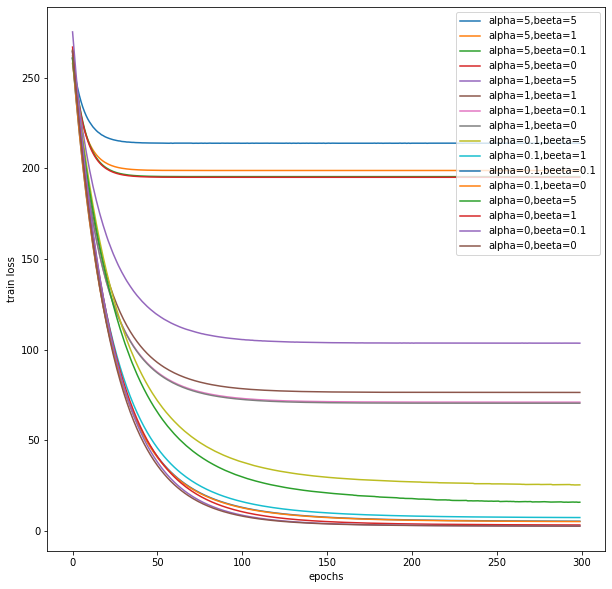

In [22]:
plt.figure(figsize=(10.,10.))
for k,alpha in enumerate([5, 1, 0.1 , 0]):
    for j,beeta in enumerate([5, 1, 0.1 , 0]):
        
        #cross validate
        w_CV, train_error_CV, test_error_CV = [],[],[]
        for i,validation_data in enumerate(Cross_Validation_data):
            remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
            X, y_train = remaining_data_for_training[:,:-1], remaining_data_for_training[:,-1:]
            Xt, y_test = validation_data[:,:-1], validation_data[:,-1:]

            w, train_error, test_error = GradientDescent_ElasticNet(X, y_train, Xt, y_test, epochs=300, lr=.01, alpha=alpha, beeta=beeta)

            w_CV.append(w)
            train_error_CV.append(train_error)
            test_error_CV.append(test_error)

        w, train_error, test_error = sum(w_CV)/5, np.array(train_error_CV).sum(axis=0)/5, np.array(test_error_CV).sum(axis=0)/5

        
#         plt.subplot(7,7,7*k+j+1)
#         plt.title("alpha={},beeta={}".format(alpha,beeta))
        plt.plot(train_error, label='alpha={},beeta={}'.format(alpha,beeta))
#         plt.plot(test_error, label='test_error {},{}'.format(alpha,beeta))
plt.xlabel('epochs')
plt.ylabel('train loss')
plt.legend()
plt.savefig('ElasticNet.png')
plt.show()

### Verifying effect of L1 in detail
In theory, it is mathematically shown that if the features of x are statistically independent then applying L1 reg. gives some of the w zero (equations are there in Ian Goodfellow book)
1. Thus, first use PCA to apply a whitening transform on the data to have whitened data
2. Then apply L1
3. Expected that we will get some w_j very close to zero

In [81]:
from sklearn import decomposition
pca=decomposition.PCA(whiten=True)
pca.fit(train_data[:,1:-1])
new_train_data = pca.transform(train_data[:,1:-1])
new_TEST_data = pca.transform(TEST_data[:,1:-1])
ones=np.ones((train_data.shape[0], 1))
new_train_data=np.hstack((ones,new_train_data,train_data[:,-1:]))
ones=np.ones((TEST_data.shape[0], 1))
new_TEST_data=np.hstack((ones,new_TEST_data,TEST_data[:,-1:]))

In [82]:
def L1_regularized_mse_loss(y_true,y_pred, alpha, w):
    return ((y_true-y_pred)**2).mean() + alpha*(np.sum(np.abs(w)))

def mse_loss(Y_true,Y_pred):
    return ((Y_true-Y_pred)**2).mean()

def GradientDescent(X_train,y_train, X_test,y_test, epochs, lr, alpha):

    train_error, test_error = [], []
    n,m=X_train.shape
    
    #initialise weights
    w = np.random.random((m,1))
    for _ in range(epochs):
        y_pred_train = X_train.dot(w)
        y_pred_test = X_test.dot(w)
        
        w_L1_gradient = np.sign(w)
        gradient = (2*((X_train.T).dot(y_pred_train - y_train)) / n) + alpha*w_L1_gradient
        
        w = w - lr * gradient
                
        train_error.append(mse_loss(y_train, y_pred_train))
        test_error.append(mse_loss(y_test, y_pred_test))
    return w, train_error, test_error

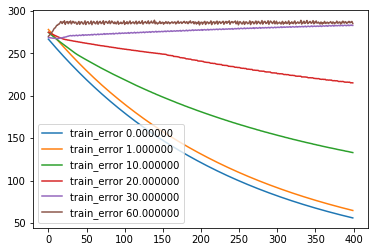

In [83]:
alphas = [0,1,10,20,30,60]
Ws = []
for alpha in alphas:
    w, _1, _2 = GradientDescent(new_train_data[:,:-1], new_train_data[:,-1:], new_TEST_data[:,:-1], new_TEST_data[:,-1:],epochs=400, lr=0.001, alpha=alpha)
    plt.plot(_1,label='train_error %f'%alpha)
#     plt.plot(_2,label='TEST_error %f'%alpha)
    plt.legend()
    Ws.append(w)
plt.show()

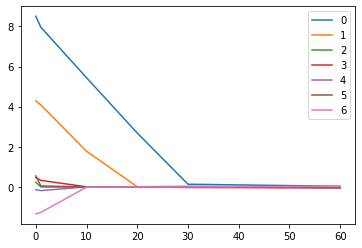

In [84]:
Ws=np.array(Ws)
for j in range(7):
    plt.plot(alphas,Ws[:,j,0],label=j)
    plt.legend()
plt.show()